# Ports

Ports are terminals through which electromagnetic waves can enter or exit a system.
In PhotonForge, they are 2D surfaces used to connect a component to the external world.
The [S parameters](S_Parameters.ipynb) of a device describes how the electromagnetic fields entering through its ports are transmitted within the component and exit through those same ports.

A [technology](../_autosummary/photonforge.Technology.rst) in PhotonForge comes with a number of predefined [port specifications](../_autosummary/photonforge.PortSpec.rst), which describe the waveguide cross-section represented by that port.

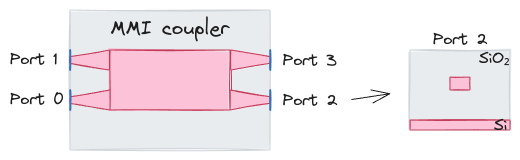

## Inspecting Ports

We will use the [basic technology](../_autosummary/photonforge.basic_technology.rst) as an example of technology from a PDK.
The [ports](../_autosummary/photonforge.Technology.rst#photonforge.Technology.ports) defined in the technology can be easily inspected:

In [1]:
import photonforge as pf

tech = pf.basic_technology()
pf.config.default_technology = tech

tech.ports

{'Rib': PortSpec(description="Rib waveguide", width=2.16, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.4, 0, (1, 0)), (2.4, 0, (3, 0)), (0.4, 0, (2, 0))}),
 'Strip': PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))})}

As we can see, the basic technology comes with 2 predefined port specifications: "Strip" and "Rib", corresponding to waveguides of different cross sections.

The specification [width](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.width) defines the lateral dimension of the waveguide cross-section, including the margins required for evanescent fields in dielectric waveguides.
Similarly, the [limits](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.limits) contain the lower and upper boundary coordinates for the cross-section in the out-of-plane (z) direction.
The actual shapes and materials of the waveguide are defined by its [path profiles](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.path_profiles), which contain `(width, offset, layer)` tuples.
These tuples are used to generate straight path sections when generating the actual waveguide.

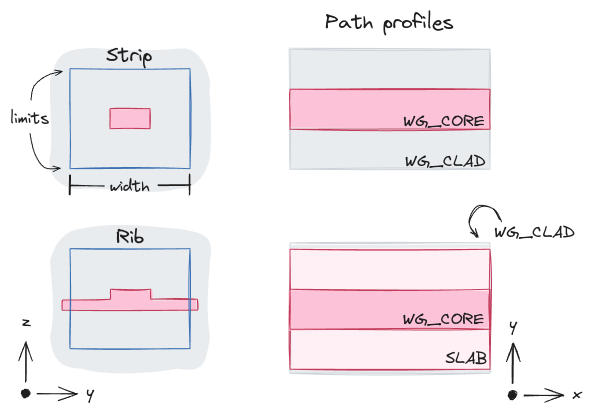

The extrusion profile for the waveguides can be quickly inspected through the [tidy3d_plot](../_autosummary/photonforge.tidy3d_plot.rst) function (only available for Tidy3D versions 2.7.1 and above):

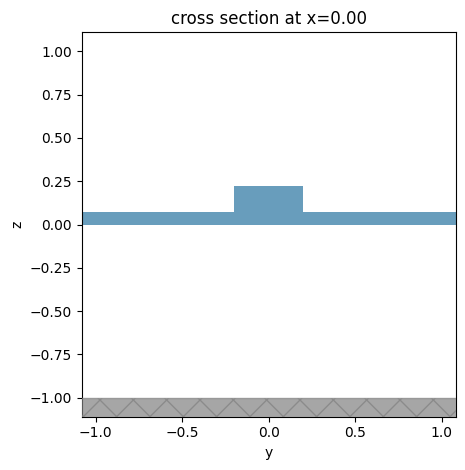

In [2]:
_ = pf.tidy3d_plot(tech.ports["Rib"])

Other attributes of the port specification define its supported modes.
Computing those modes can be easily done though Tidy3D's mode solver by exporting the specification [to tidy3d](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.to_tidy3d):

wavelength    n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                 
1.934145e+14 0                 1.55  2.40691    0.0           0.97718   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                  0.81759        0.804347   0.206934

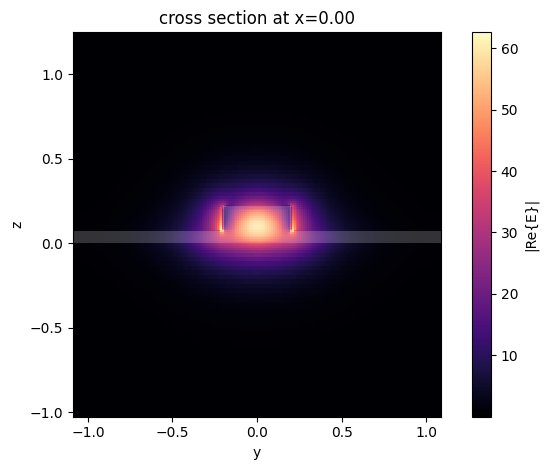

In [3]:
rib = tech.ports["Rib"]
freqs = [pf.C_0 / 1.55]

mode_solver = rib.to_tidy3d(freqs, mesh_refinement=40)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

## Custom Port Specification

If we need to use a custom waveguide profile, it's easy to create a new port specification.
For example, let's add a multimode strip profile with an 800 nm core width, and a vertical slot waveguide.
Note that we follow the technology defaults of including the cladding region surrounding the waveguide core in the "WG_CLAD" layer `(1, 0)`, expanding beyond the port width.

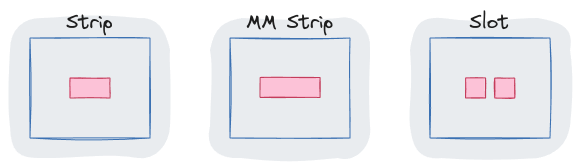

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.699595    0.0          0.995523   
             1                 1.55  2.097767    0.0          0.953773   
             2                 1.55  1.955900    0.0          0.033955   
             3                 1.55  1.527858    0.0          0.174635   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.877616        0.816402   0.200188  
             1                 0.615339        0.865615   0.345752  
             2                 0.639355        0.920360   0.377286  
             3                 0.836501        0.648379   0.682208

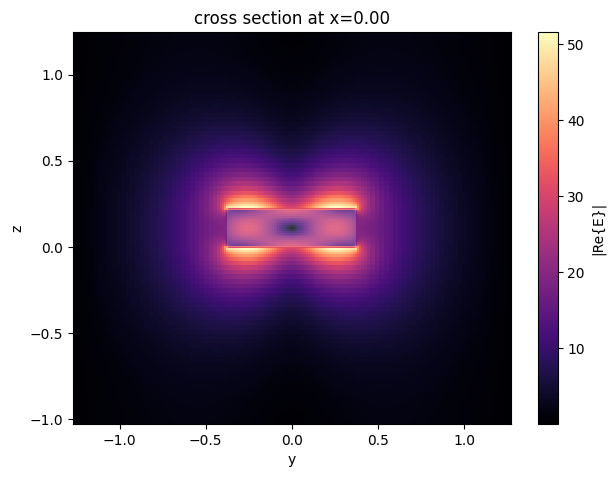

In [4]:
strip_mm = pf.PortSpec(
    "Multimode strip waveguide",
    width=2.5,
    limits=tech.ports["Strip"].limits,
    num_modes=4,
    target_neff=4,
    path_profiles={(2.6, 0, (1, 0)), (0.75, 0, (2, 0))},
)

mode_solver = strip_mm.to_tidy3d(freqs, mesh_refinement=40)
mode_solver.plot_field("E", mode_index=3, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.687996    0.0          0.965267   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.871396        0.855663   0.158515

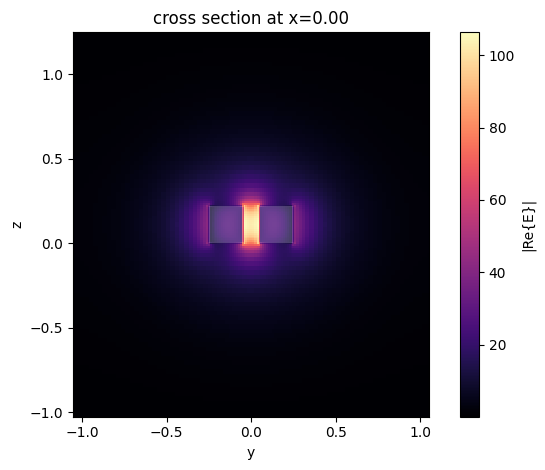

In [5]:
slot = pf.PortSpec(
    "Slot waveguide",
    width=2.1,
    limits=tech.ports["Strip"].limits,
    num_modes=1,
    target_neff=4,
    path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))},
)

mode_solver = slot.to_tidy3d(freqs, mesh_refinement=40)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

We can even [add](../_autosummary/photonforge.Technology.rst#photonforge.Technology.add_port) our new specifications to the technology, if we want to:

In [6]:
tech.add_port("Strip MM", strip_mm)
tech.add_port("Slot", slot)

tech.ports

{'Slot': PortSpec(description="Slot waveguide", width=2.1, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))}),
 'Strip MM': PortSpec(description="Multimode strip waveguide", width=2.5, limits=(-1, 1.22), num_modes=4, polarization="", target_neff=4, path_profiles={(0.75, 0, (2, 0)), (2.6, 0, (1, 0))}),
 'Rib': PortSpec(description="Rib waveguide", width=2.16, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.4, 0, (1, 0)), (2.4, 0, (3, 0)), (0.4, 0, (2, 0))}),
 'Strip': PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))})}

### Modifying Parametric Technologies

If a parametric technology is [updated](../_autosummary/photonforge.Technology.rst#photonforge.Technology.update) (in a Monte Carlo analysis, for example), the added port specifications will be lost.
The proper way of adding a port specification to a pre-existing parametric technology is to wrap it:

In [7]:
@pf.parametric_technology
def custom_basic_technology(*args, **kwargs):
    technology = pf.basic_technology(*args, **kwargs)
    slot = pf.PortSpec(
        "Slot waveguide",
        width=2.1,
        limits=tech.ports["Strip"].limits,
        num_modes=1,
        target_neff=4,
        path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))},
    )
    technology.add_port("Slot", slot)
    return technology

custom_tech = custom_basic_technology()
pf.config.default_technology = custom_tech

custom_tech.ports

{'Slot': PortSpec(description="Slot waveguide", width=2.1, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))}),
 'Rib': PortSpec(description="Rib waveguide", width=2.16, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.4, 0, (1, 0)), (2.4, 0, (3, 0)), (0.4, 0, (2, 0))}),
 'Strip': PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))})}

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.477255    0.0          0.981416   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                  0.95209         0.90721   0.743313

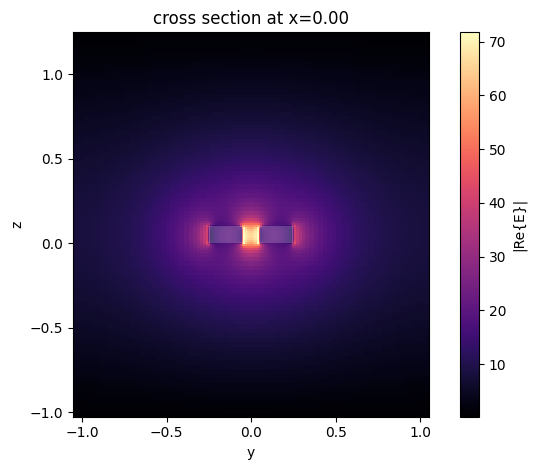

In [8]:
custom_tech.update(core_thickness=0.1)

mode_solver = custom_tech.ports["Slot"].to_tidy3d(freqs, mesh_refinement=40)
mode_solver.plot_field("E", mode_index=0, f=freqs[0], robust=False)
mode_solver.data.to_dataframe()

## Waveguides

We can easily create a waveguide corresponding to a port specification using the [get_paths](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.get_paths) function:

In [9]:
strip = tech.ports["Slot"]

# Use a component for setting layers and visualization
connection = pf.Component("CONNECTION")

for layer, path in strip.get_paths((0, 0)):
    path.segment((5, 0)).turn(90, 4).segment((9, 6))
    connection.add(layer, path)

connection

## Adding Ports to a Component

To [add](../_autosummary/photonforge.Component.rst#photonforge.Component.add_port) a [port](../_autosummary/photonforge.Port.rst) to a component, we first need to create it by setting its position, orientation (input direction) and specification.

In [10]:
port0 = pf.Port((0, 0), 0, "Slot")

# Set the port name to "P0"
connection.add_port(port0, "P0")

connection

Another option is to use port [auto-detection](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports) to look for possible ports in the component.

Auto-detection works by matching the required path profiled in the port specifications to the **edges** in the component geometry, which means:

1. There can be false positives if a port profile is very simple and it matches several edges in the component geometry.

   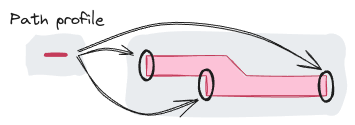

3. Ports will not be found if, for example, a clad layer is required to surround the waveguide core, but only the core edge is found

   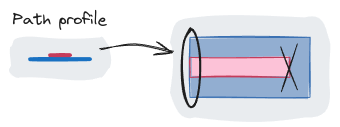

In [11]:
detected_ports = connection.detect_ports(["Slot"])
detected_ports

[Port(center=(9, 6), input_direction=270, spec=PortSpec(description="Slot waveguide", width=2.1, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.2, 0, (1, 0)), (0.2, -0.15, (2, 0)), (0.2, 0.15, (2, 0))}), extended=True, inverted=False)]

Note that the auto-detection skipped the port at (0, 0) because it was already present in the component (it does not create duplicates).

In [12]:
connection.add_port(detected_ports[0], "P1")
connection